In [1]:
import warnings
warnings.filterwarnings('ignore')

### Data Preparation for Apriori Algorithm

According to the requirements, **each disease represents a "basket"** and the "items" in this basket are the symptoms that appear for that disease.

**Data Preparation Strategy:**
- We group all cases of the same disease together
- Each disease becomes a transaction (basket) containing all unique symptoms that appear for that disease across all cases
- This approach identifies symptom combinations that frequently co-occur within the same disease profile

**Data Cleaning and Normalization:**
- Normalize symptom synonyms (e.g., "fever" vs "pyrexia", "vomit" vs "vomiting")
- Remove extra spaces and underscores
- Validate minimum number of transactions to ensure robust frequent itemsets


# Task 1: Symptom Co-occurrence Analysis

## Objective
The goal of this task is to analyse the co-occurrence patterns of different symptoms within disease profiles. Specifically, the task aims to identify combinations of symptoms that frequently appear together in the same disease.

## Method
Implement the Apriori algorithm to analyse the Disease Symptom dataset, identifying common combinations of symptoms that frequently co-occur within the same disease profile.


## 1. Setup and Environment
Helper functions are created in the src folder to process our datasets and mine patterns in our data. Below are the 2 files used to implement these functions:

- SymptomDataProcessor
    - Contains functions to clean and create "baskets" for each transaction

- SymptomPatternMiner
    - Contains functions to encode the items and perform pattern mining

In [2]:
import sys
from pathlib import Path
import numpy as np
from collections import Counter
import ast
import importlib

# Add project root to Python path to import custom modules
project_root = Path().resolve().parent.parent
sys.path.append(str(project_root))

from src.processors.symptom_data_processor import SymptomDataProcessor
from src.analysis.symptom_pattern_miner import SymptomPatternMiner

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries and modules imported successfully.")

Libraries and modules imported successfully.


## 2. Data Loading and Preprocessing
First we load the dataset for **Disease Symptom**, which contains information linking diseases to their associated symptoms

Data Columns:
* *Disease:* Name of the disease
* *Symptom_1* to *Symptom_17*: Various symptoms associated with each disease

We also have additional files containing *symptom descriptions*, *precautions* and *severity weights*



### Data Preprocessing

**Data Preparation:** We start by grouping the symptoms into "baskets", so each disease has a list of symptoms that appear with it

**Data Cleaning:** To avoid redundancy, we have normalized the names of the symptoms and removed any spaces or underscores

In [3]:
# Define the path to the dataset using the project_root variable
# This ensures the path is always correct, regardless of where the notebook is run
DATA_PATH = project_root / 'data' / 'dataset.csv'

# Initialize and run the data processor
processor = SymptomDataProcessor(data_path=DATA_PATH)
transactions = processor.process_data(group_by_disease=True, min_transactions=10)

print(f"Successfully processed {len(transactions)} transactions (disease baskets).")
print(f"Example transaction (disease basket): {transactions[0]}")

# Display statistics about the data
total_symptoms = sum(len(t) for t in transactions)
avg_symptoms_per_disease = total_symptoms / len(transactions)
print(f"\nData Statistics:")
print(f"  Total diseases: {len(transactions)}")
print(f"  Total symptoms across all diseases: {total_symptoms}")
print(f"  Average symptoms per disease: {avg_symptoms_per_disease:.2f}")


Processing symptoms: 100%|██████████| 4920/4920 [00:00<00:00, 28265.75it/s]

Successfully processed 41 transactions (disease baskets).
Example transaction (disease basket): ['dischromic patches', 'skin rash', 'itching', 'nodal skin eruptions']

Data Statistics:
  Total diseases: 41
  Total symptoms across all diseases: 297
  Average symptoms per disease: 7.24


In [4]:
for i in transactions:
    if 'vomit' in i:
        print(i)

## 3. Apriori Algorithm and Association Rule Mining
We will be using the implementation of `apriori` from `mlxtend` to mine the frequent itemsets in our dataset
- A `min_support` of 0.02 is used to generate the frequent itemsets

TODO: Maybe can play around to see what support is good (Maybe 2-10%?) -- Then we can justify it with some reason too (like put support higher so we dont generate itemsets that are not informative)

From here, we can then generate some association rules
- With the generated rules, we can analyse the different patterns of symptoms associated with different diseases

In [5]:
# Set a minimum support level of 3%
miner = SymptomPatternMiner(transactions, min_support=0.03)

# Mine for frequent itemsets
frequent_itemsets = miner.mine_frequent_itemsets()

print(f"\nFound {len(frequent_itemsets)} frequent itemsets.")
print(f"Itemset sizes range from 1 to {frequent_itemsets['itemsets'].apply(len).max()}")

# Generate association rules with a minimum confidence of 50%
rules = miner.generate_association_rules(metric="confidence", min_threshold=0.5)
print(f"Generated {len(rules)} association rules with confidence >= 0.5")

# Save Results to CSV
# This allows the analysis section to load pre-computed results,
# either from this run or from a previous run of the `symptom_analysis.py` script.
output_dir = project_root / 'outputs'
output_dir.mkdir(exist_ok=True) # Ensure the directory exists

# Save as pickle to preserve the data structure
itemsets_path = output_dir / 'frequent_itemsets.pkl'
rules_path = output_dir / 'association_rules.pkl'

frequent_itemsets.to_pickle(itemsets_path)
rules.to_pickle(rules_path)

print("Frequent itemsets and association rules have been saved to the 'outputs' directory.")
print(f"Itemsets saved to: {itemsets_path}")
print(f"Rules saved to: {rules_path}")


Found 928 frequent itemsets.
Itemset sizes range from 1 to 8
Generated 12269 association rules with confidence >= 0.5
Frequent itemsets and association rules have been saved to the 'outputs' directory.
Itemsets saved to: /Users/chengyao/Documents/GitHub/SC4020-Group-Project-2/outputs/frequent_itemsets.pkl
Rules saved to: /Users/chengyao/Documents/GitHub/SC4020-Group-Project-2/outputs/association_rules.pkl


## 4. Load and Analyze Results

The pre-computed results from the `outputs` directory will be loaded to avoid rerunning the itemsets and rules generation. 

These files can be generated by running the cell above, or by running the main analysis script: `python scripts/symptom_analysis.py`.

This separates the time-consuming mining process from the interactive analysis and visualization.

In [6]:
# Load the frequent itemsets and association rules from the pickle files saved in the 'outputs' directory.
itemsets_path = project_root / 'outputs' / 'frequent_itemsets.pkl'
rules_path = project_root / 'outputs' / 'association_rules.pkl'

saved_frequent_itemsets = pd.read_pickle(itemsets_path)
saved_rules = pd.read_pickle(rules_path)

print("Successfully loaded pre-computed results from pickle files.")

Successfully loaded pre-computed results from pickle files.


### Analysing Frequent Itemsets
After getting the list of frequent itemsets, we can take a look at the distribution of the number of symptoms in each of the itemsets to get a good sensing of the number of symptoms in our itemsets


FREQUENT ITEMSETS ANALYSIS

Itemset size distribution:
  Size 1: 48 itemsets
  Size 2: 159 itemsets
  Size 3: 254 itemsets
  Size 4: 236 itemsets
  Size 5: 148 itemsets
  Size 6: 64 itemsets
  Size 7: 17 itemsets
  Size 8: 2 itemsets


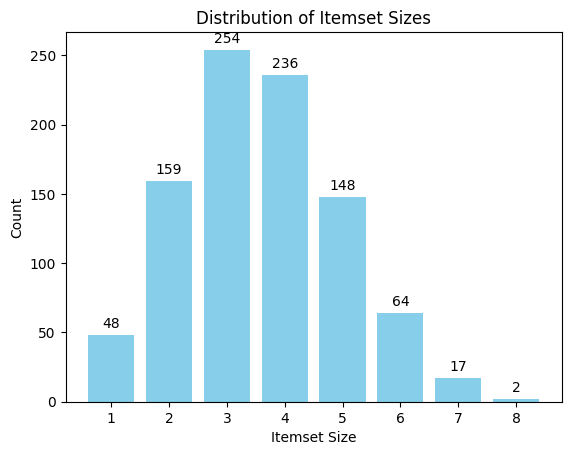

In [7]:
# Analyze frequent itemsets by size
print("\n" + "="*60)
print("FREQUENT ITEMSETS ANALYSIS")
print("="*60)

# Group by itemset size
saved_frequent_itemsets['itemset_size'] = saved_frequent_itemsets['itemsets'].apply(len)
size_counts = saved_frequent_itemsets.groupby('itemset_size').size()
print(f"\nItemset size distribution:")
for size, count in size_counts.items():
    print(f"  Size {size}: {count} itemsets")

bars = plt.bar(size_counts.index, size_counts.values, color='skyblue')
plt.xticks(size_counts.index)
plt.bar_label(bars, padding=3)
plt.xlabel('Itemset Size')
plt.ylabel('Count')
plt.title('Distribution of Itemset Sizes')
plt.show()


From the bar plot, we can see that the **most common itemset size** is **3**, and the distribution appears to be fairly uniform, with a slight right skew (due to the 2 itemsets with 8 elements forming a longer right tail)

## Analysis of results

After the general overview, we can dive deeper to extract more information from the itemsets.

We will load the **Top 10 Most Frequent Itemsets**, along with the **Top 10 Most Cofident Association Rules**. An explanation of the association rules and the terms involved will be provided below the cell output.

### Top 10 Most Frequent Single Symptoms

In [8]:
print(f"\nTop 10 Most Frequent Single Symptoms:")
single_symptoms = saved_frequent_itemsets[saved_frequent_itemsets['itemset_size'] == 1].nlargest(10, 'support')
for idx, row in single_symptoms.iterrows():
    symptom = list(row['itemsets'])[0]
    print(f"  {symptom}: {row['support']:.4f} ({row['support']*100:.2f}% of diseases)")


Top 10 Most Frequent Single Symptoms:
  vomiting: 0.4390 (43.90% of diseases)
  fatigue: 0.4146 (41.46% of diseases)
  high fever: 0.2927 (29.27% of diseases)
  abdominal pain: 0.2683 (26.83% of diseases)
  headache: 0.2439 (24.39% of diseases)
  loss of appetite: 0.2439 (24.39% of diseases)
  yellowish skin: 0.1951 (19.51% of diseases)
  chills: 0.1707 (17.07% of diseases)
  itching: 0.1707 (17.07% of diseases)
  skin rash: 0.1707 (17.07% of diseases)


### Top 10 Most Frequent Symptom Combinations (size >= 2)

In [15]:
print(f"\nTop 10 Most Frequent Symptom Combinations (size >= 2):")
multi_symptoms = saved_frequent_itemsets[saved_frequent_itemsets['itemset_size'] >= 2].nlargest(10, 'support')
for idx, row in multi_symptoms.iterrows():
    symptoms = ', '.join(list(row['itemsets']))
    print(f"  {{{symptoms}}}: {row['support']:.4f} ({row['support']*100:.2f}% of diseases)")



Top 10 Most Frequent Symptom Combinations (size >= 2):
  {abdominal pain, vomiting}: 0.2195 (21.95% of diseases)
  {high fever, fatigue}: 0.2195 (21.95% of diseases)
  {fatigue, vomiting}: 0.1951 (19.51% of diseases)
  {loss of appetite, vomiting}: 0.1951 (19.51% of diseases)
  {abdominal pain, yellowish skin}: 0.1707 (17.07% of diseases)
  {fatigue, loss of appetite}: 0.1707 (17.07% of diseases)
  {loss of appetite, yellowing of eyes}: 0.1707 (17.07% of diseases)
  {yellowish skin, vomiting}: 0.1707 (17.07% of diseases)
  {abdominal pain, loss of appetite}: 0.1463 (14.63% of diseases)
  {chills, high fever}: 0.1463 (14.63% of diseases)


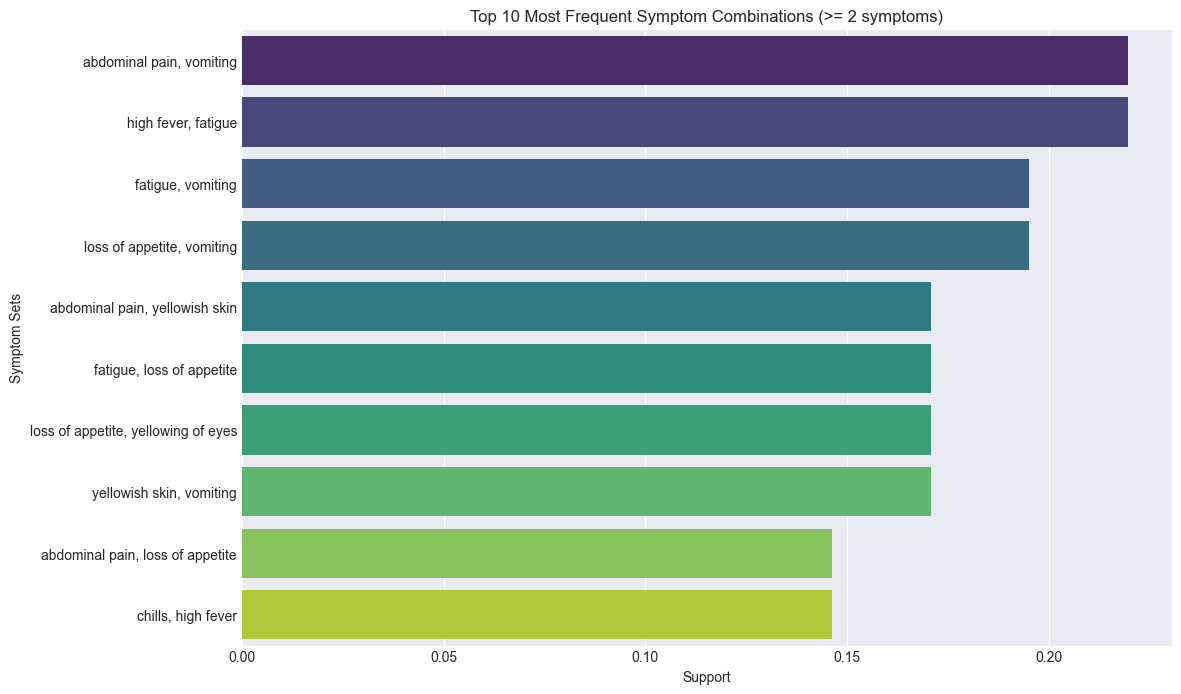


Top 10 Most Frequent Symptom Combinations ({Symptoms Combination}:support):
1. {abdominal pain, vomiting}: 0.2195 (21.95% of diseases)
2. {high fever, fatigue}: 0.2195 (21.95% of diseases)
3. {fatigue, vomiting}: 0.1951 (19.51% of diseases)
4. {loss of appetite, vomiting}: 0.1951 (19.51% of diseases)
5. {abdominal pain, yellowish skin}: 0.1707 (17.07% of diseases)
6. {fatigue, loss of appetite}: 0.1707 (17.07% of diseases)
7. {loss of appetite, yellowing of eyes}: 0.1707 (17.07% of diseases)
8. {yellowish skin, vomiting}: 0.1707 (17.07% of diseases)
9. {abdominal pain, loss of appetite}: 0.1463 (14.63% of diseases)
10. {chills, high fever}: 0.1463 (14.63% of diseases)


In [23]:
# Plot Top 10 Most Frequent Symptom Combinations (size >= 2)
top_itemsets = saved_frequent_itemsets[saved_frequent_itemsets['itemset_size'] >= 2].nlargest(10, 'support').copy()
top_itemsets['itemsets_str'] = top_itemsets['itemsets'].apply(lambda x: ', '.join(list(x)))

plt.figure(figsize=(12, 8))
sns.barplot(x='support', y='itemsets_str', data=top_itemsets, palette='viridis')
plt.title('Top 10 Most Frequent Symptom Combinations (>= 2 symptoms)')
plt.xlabel('Support')
plt.ylabel('Symptom Sets')
plt.show()

print("\nTop 10 Most Frequent Symptom Combinations ({Symptoms Combination}:support):")
for i, (idx, row) in enumerate(top_itemsets.iterrows(), 1):
    symptoms = row['itemsets_str']
    print(f"{i}. {{{symptoms}}}: {row['support']:.4f} ({row['support']*100:.2f}% of diseases)")


### Association Rules

### Top 10 Rules by confidence

In [10]:
print(f"\nTotal rules generated: {len(saved_rules)}")
print(f"\nTop 10 Rules by Confidence:")
top_conf = saved_rules.nlargest(10, 'confidence')
for idx, row in top_conf.iterrows():
    ante = ', '.join(list(row['antecedents']))
    cons = ', '.join(list(row['consequents']))
    print(f"  IF {{{ante}}} THEN {{{cons}}}")
    print(f"     Confidence: {row['confidence']:.4f}, Lift: {row['lift']:.4f}, Support: {row['support']:.4f}")



Total rules generated: 12269

Top 10 Rules by Confidence:
  IF {dark urine} THEN {abdominal pain}
     Confidence: 1.0000, Lift: 3.7273, Support: 0.1220
  IF {abnormal menstruation} THEN {fatigue}
     Confidence: 1.0000, Lift: 2.4118, Support: 0.0488
  IF {abnormal menstruation} THEN {irritability}
     Confidence: 1.0000, Lift: 10.2500, Support: 0.0488
  IF {mood swings} THEN {abnormal menstruation}
     Confidence: 1.0000, Lift: 20.5000, Support: 0.0488
  IF {abnormal menstruation} THEN {mood swings}
     Confidence: 1.0000, Lift: 20.5000, Support: 0.0488
  IF {blurred and distorted vision} THEN {increased appetite}
     Confidence: 1.0000, Lift: 10.2500, Support: 0.0732
  IF {phlegm} THEN {chest pain}
     Confidence: 1.0000, Lift: 6.8333, Support: 0.0732
  IF {continuous sneezing} THEN {chills}
     Confidence: 1.0000, Lift: 5.8571, Support: 0.0488
  IF {phlegm} THEN {chills}
     Confidence: 1.0000, Lift: 5.8571, Support: 0.0732
  IF {phlegm} THEN {cough}
     Confidence: 1.0000

### Top 10 Rules by Lift (strongest associations)

In [11]:
print(f"\nTop 10 Rules by Lift (strongest associations):")
top_lift = saved_rules.nlargest(10, 'lift')
for idx, row in top_lift.iterrows():
    ante = ', '.join(list(row['antecedents']))
    cons = ', '.join(list(row['consequents']))
    print(f"  IF {{{ante}}} THEN {{{cons}}}")
    print(f"     Lift: {row['lift']:.4f}, Confidence: {row['confidence']:.4f}, Support: {row['support']:.4f}")



Top 10 Rules by Lift (strongest associations):
  IF {mood swings} THEN {abnormal menstruation}
     Lift: 20.5000, Confidence: 1.0000, Support: 0.0488
  IF {abnormal menstruation} THEN {mood swings}
     Lift: 20.5000, Confidence: 1.0000, Support: 0.0488
  IF {swelling joints} THEN {painful walking}
     Lift: 20.5000, Confidence: 1.0000, Support: 0.0488
  IF {painful walking} THEN {swelling joints}
     Lift: 20.5000, Confidence: 1.0000, Support: 0.0488
  IF {mood swings, fatigue} THEN {abnormal menstruation}
     Lift: 20.5000, Confidence: 1.0000, Support: 0.0488
  IF {fatigue, abnormal menstruation} THEN {mood swings}
     Lift: 20.5000, Confidence: 1.0000, Support: 0.0488
  IF {mood swings} THEN {fatigue, abnormal menstruation}
     Lift: 20.5000, Confidence: 1.0000, Support: 0.0488
  IF {abnormal menstruation} THEN {mood swings, fatigue}
     Lift: 20.5000, Confidence: 1.0000, Support: 0.0488
  IF {mood swings, irritability} THEN {abnormal menstruation}
     Lift: 20.5000, Confid

In [12]:
print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Total transactions (disease baskets): {len(transactions)}")
print(f"Total frequent itemsets: {len(saved_frequent_itemsets)}")
print(f"Total association rules: {len(saved_rules)}")
print(f"Average confidence: {saved_rules['confidence'].mean():.4f}")
print(f"Average lift: {saved_rules['lift'].mean():.4f}")
print(f"Rules with lift > 1.5 (strong positive association): {(saved_rules['lift'] > 1.5).sum()}")


SUMMARY
Total transactions (disease baskets): 41
Total frequent itemsets: 928
Total association rules: 12269
Average confidence: 0.8005
Average lift: 9.2926
Rules with lift > 1.5 (strong positive association): 12228


In [13]:
# Display top 10 itemsets and rules tables
print("\nFrequent Itemsets (Top 10):")
display(saved_frequent_itemsets.head(10))

print("\nAssociation Rules (Top 10):")
display(saved_rules.head(10))


Frequent Itemsets (Top 10):


,support,itemsets,itemset_size
0,0.268293,(abdominal pain),1
1,0.048780,(abnormal menstruation),1
2,0.048780,(acidity),1
3,0.048780,(back pain),1
4,0.073171,(blurred and distorted vision),1
5,0.097561,(breathlessness),1
6,0.146341,(chest pain),1
7,0.170732,(chills),1
8,0.048780,(constipation),1
9,0.048780,(continuous sneezing),1



Association Rules (Top 10):


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(dark urine),(abdominal pain),0.121951,0.268293,0.121951,1.000000,3.727273,0.089233,inf,0.833333
1,(itching),(abdominal pain),0.170732,0.268293,0.121951,0.714286,2.662338,0.076145,2.560976,0.752941
2,(joint pain),(abdominal pain),0.146341,0.268293,0.073171,0.500000,1.863636,0.033908,1.463415,0.542857
3,(abdominal pain),(loss of appetite),0.268293,0.243902,0.146341,0.545455,2.236364,0.080904,1.663415,0.755556
4,(loss of appetite),(abdominal pain),0.243902,0.268293,0.146341,0.600000,2.236364,0.080904,1.829268,0.731183
5,(abdominal pain),(vomiting),0.268293,0.439024,0.219512,0.818182,1.863636,0.101725,3.085366,0.633333
6,(vomiting),(abdominal pain),0.439024,0.268293,0.219512,0.500000,1.863636,0.101725,1.463415,0.826087
7,(yellowing of eyes),(abdominal pain),0.170732,0.268293,0.121951,0.714286,2.662338,0.076145,2.560976,0.752941
8,(abdominal pain),(yellowish skin),0.268293,0.195122,0.170732,0.636364,3.261364,0.118382,2.213415,0.947619
9,(yellowish skin),(abdominal pain),0.195122,0.268293,0.170732,0.875000,3.261364,0.118382,5.853659,0.861472


### Explanation of Association Rule Metrics
This section provides explanations for the terms used in the association rules.

For a rule **"IF {A} THEN {B}"**:

| Column | Simple Explanation | In Technical Terms |
| :--- | :--- | :--- |
| **`antecedents`** | The "IF" part of the rule. This is symptom set {A}. | `antecedents` |
| **`consequents`** | The "THEN" part of the rule. This is symptom set {B}. | `consequents` |
| **`antecedent support`** | How often symptom {A} appears in the entire dataset. | `support(A)` |
| **`consequent support`** | How often symptom {B} appears in the entire dataset. | `support(B)` |
| **`support`** | How often {A} and {B} appear **together** in the dataset. | `support(A U B)` |
| **`confidence`** | **The rule's reliability.** "If a patient has {A}, what's the probability they also have {B}?" Higher is better. | `support(A U B) / support(A)` |
| **`lift`** | **The rule's importance.** How much more likely {B} is to appear when {A} is present. `> 1` is good. Higher is better. | `confidence(A->B) / support(B)` |
| **`leverage`** | The difference between how often {A} and {B} appear together versus how often they would if they were independent. `> 0` means they appear together more than expected. | `support(A U B) - (support(A) * support(B))` |
| **`conviction`** | A measure of the rule's implication. A high value means the consequent {B} is highly dependent on the antecedent {A}. An `inf` (infinity) value is very strong. | `(1 - support(B)) / (1 - confidence(A->B))` |
| **`zhangs_metric`** | A more advanced measure of association that ranges from -1 (perfect negative correlation) to +1 (perfect positive correlation). 0 indicates independence. | A value that considers both support and confidence. |
| **`kulczynski`** | The average of the two confidence scores (`A->B` and `B->A`). It's a symmetric measure of how strongly the two are related. | `0.5 * (confidence(A->B) + confidence(B->A))` |


## 5. Visualization


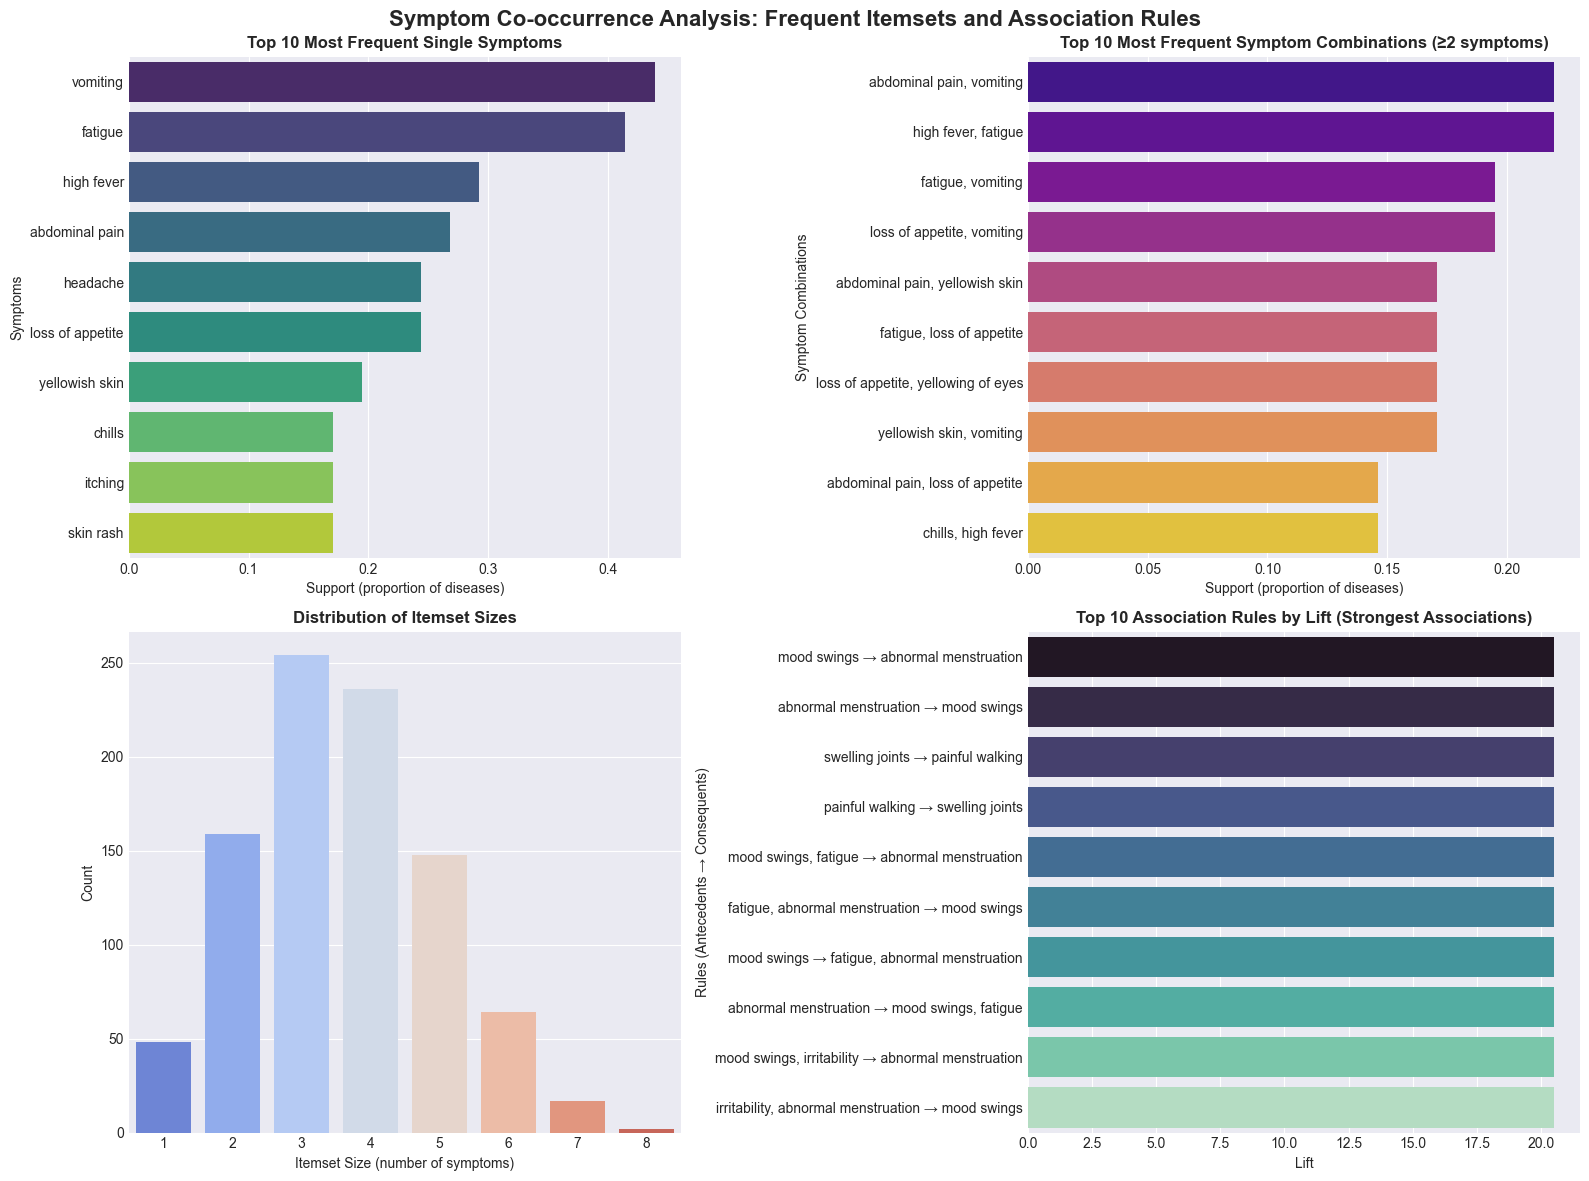

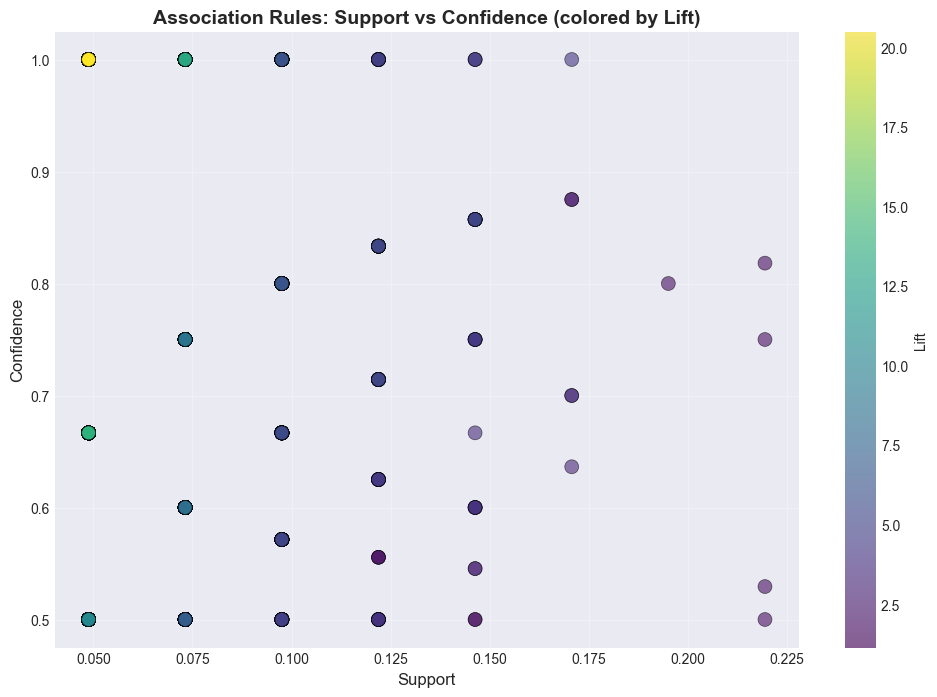

In [25]:
# Enhanced visualizations for symptom co-occurrence analysis
# Set up the plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Symptom Co-occurrence Analysis: Frequent Itemsets and Association Rules', 
             fontsize=16, fontweight='bold')

# 1. Top 10 Most Frequent Single Symptoms
ax1 = axes[0, 0]
single_symptoms = saved_frequent_itemsets[saved_frequent_itemsets['itemset_size'] == 1].nlargest(10, 'support')
single_symptoms['itemsets_str'] = single_symptoms['itemsets'].apply(
    lambda x: list(x)[0] if isinstance(x, (set, frozenset)) else str(x)
)
sns.barplot(x='support', y='itemsets_str', data=single_symptoms, ax=ax1, palette='viridis')
ax1.set_title('Top 10 Most Frequent Single Symptoms', fontweight='bold')
ax1.set_xlabel('Support (proportion of diseases)')
ax1.set_ylabel('Symptoms')

# 2. Top 10 Most Frequent Symptom Combinations (size >= 2)
ax2 = axes[0, 1]
multi_symptoms = saved_frequent_itemsets[saved_frequent_itemsets['itemset_size'] >= 2].nlargest(10, 'support')
multi_symptoms['itemsets_str'] = multi_symptoms['itemsets'].apply(
    lambda x: ', '.join(list(x)) if isinstance(x, (set, frozenset)) else str(x)
)
sns.barplot(x='support', y='itemsets_str', data=multi_symptoms, ax=ax2, palette='plasma')
ax2.set_title('Top 10 Most Frequent Symptom Combinations (≥2 symptoms)', fontweight='bold')
ax2.set_xlabel('Support (proportion of diseases)')
ax2.set_ylabel('Symptom Combinations')

# 3. Distribution of Itemset Sizes
ax3 = axes[1, 0]
size_counts = saved_frequent_itemsets['itemset_size'].value_counts().sort_index()
sns.barplot(x=size_counts.index, y=size_counts.values, ax=ax3, palette='coolwarm')
ax3.set_title('Distribution of Itemset Sizes', fontweight='bold')
ax3.set_xlabel('Itemset Size (number of symptoms)')
ax3.set_ylabel('Count')

# 4. Top 10 Association Rules by Lift
ax4 = axes[1, 1]
top_rules = saved_rules.nlargest(10, 'lift')
top_rules['rule_str'] = top_rules.apply(
    lambda row: f"{', '.join(list(row['antecedents']))} → {', '.join(list(row['consequents']))}", 
    axis=1
)
sns.barplot(x='lift', y='rule_str', data=top_rules, ax=ax4, palette='mako')
ax4.set_title('Top 10 Association Rules by Lift (Strongest Associations)', fontweight='bold')
ax4.set_xlabel('Lift')
ax4.set_ylabel('Rules (Antecedents → Consequents)')

plt.tight_layout()
plt.show()

# Additional visualization: Support vs Confidence scatter plot for rules
plt.figure(figsize=(12, 8))
scatter = plt.scatter(saved_rules['support'], saved_rules['confidence'], 
                     c=saved_rules['lift'], cmap='viridis', 
                     s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Lift')
plt.xlabel('Support', fontsize=12)
plt.ylabel('Confidence', fontsize=12)
plt.title('Association Rules: Support vs Confidence (colored by Lift)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()



# TODO:
- Include diseases into the analysis
- Deep dives:
    - Look into rules with high confidence and lifts
    - Look into symptoms with lower support (uncommon) but strong association (Zhang’s metric or Jaccard index)
    - *Leverage and Conviction (Need to look into this more*)
- Rule pruning (remove rules that dont meet confidence or lift)
- **(Stretch)** Test Hypotheses
    - Eg: Based on the frequent itemsets and rules, you can form hypotheses about possible disease-symptom relationships: For example, if "abdominal pain" often co-occurs with dark urine, it could suggest a relationship with liver diseases or kidney issues. Investigating this with medical knowledge or literature can help confirm or refute these associations.